## pose detection

In [3]:
from glob import glob
image_dir = './MPII/images'
image_data = glob(f'{image_dir}/*.jpg')
print(len(image_data))

24984


In [34]:
import json

# JSON 파일 경로
file_path = './MPII/annotation/mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_2/valid.json'

# 파일 열기 및 읽기
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 데이터 출력 (필요 시 확인)
print(len(data))

check = []
for i in range(len(data)):
    check.append(data[i]['image'])

test_image = []
for i in range(len(check)):
    if check.count(check[i]) == 1:
        temp = image_dir + '/' + check[i]
        if temp in image_data:
            test_image.append(temp)
print(len(test_image))

2958
2514


In [35]:
test_image.sort()
print(test_image[0])

./MPII/images/000025245.jpg


In [36]:
test_label = []
for i in range(len(test_image)):
    for j in range(len(data)):
        if test_image[i].split('/')[-1] == data[j]['image']:
            test_label.append({'name' : data[j]['image'], 'label' : data[j]['joints'], 'scale' : data[j]['scale'], 'center' : data[j]['center']})

In [40]:
test_image_100 = test_image[:100]
test_label_100 = test_label[:100]

In [38]:
print(len(test_image))
print(len(test_label))

2514
2514


## Ground Truth

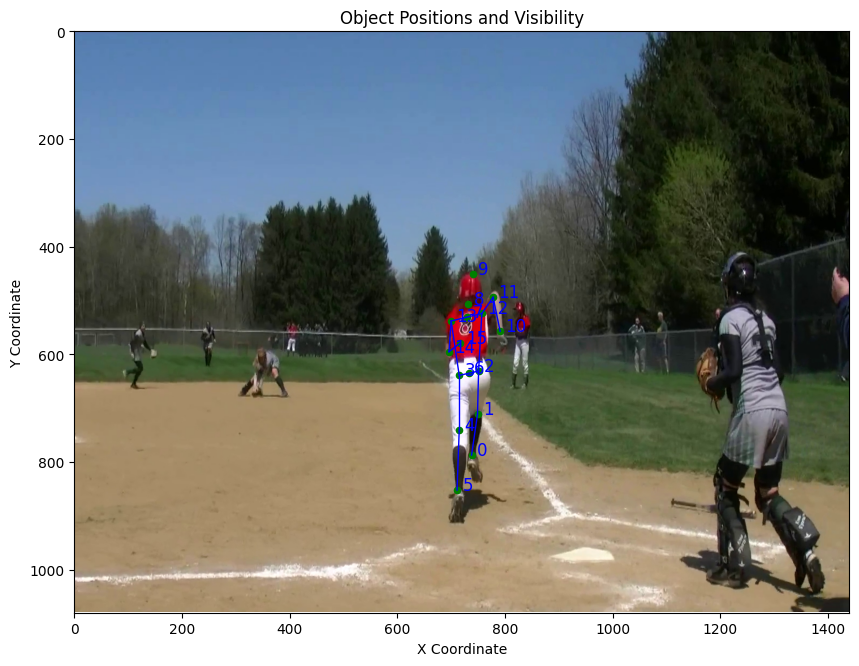

In [39]:
import matplotlib.pyplot as plt
import cv2

data = test_label[6]['label']
# 빈 리스트를 만들어서 x, y, id, visible 데이터를 분리
x_coords = [val[0] if val[0] != -1 else 0 for val in data]
y_coords = [val[1] if val[1] != -1 else 0 for val in data]
ids = [i if x_coords[i] != 0 else 0 for i in range(16)]
# visibilities = [int(v[0]) if v.size > 0 else 0 for v in data['is_visible']]

# 배경 이미지 로드 (파일 경로를 변경)
background_image_path = f'{test_image[6]}'  # 사용하고자 하는 이미지 파일 경로를 입력하세요.
# background_image_path = './MPII/images/068325876.jpg'
background = cv2.imread(background_image_path)

# 이미지가 정상적으로 불러와졌는지 확인
if background is None:
    raise ValueError("배경 이미지를 불러올 수 없습니다. 파일 경로를 확인하세요.")

# 이미지를 RGB로 변환 (OpenCV는 BGR로 이미지를 읽기 때문에, plt에서는 RGB로 변환 필요)
background_rgb = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)

# Plot 설정
plt.figure(figsize=(10, 8))

# 배경 이미지 표시
plt.imshow(background_rgb)

# 가시성에 따라 점을 색으로 구분
for i, (x, y, obj_id) in enumerate(zip(x_coords, y_coords, ids)):
    color = 'green'  # 가시성이 있으면 초록색, 없으면 빨간색
    if x != 0:
        plt.scatter(x, y, color=color, s=20)  # 좌표에 점을 찍음
        plt.text(x + 10, y, str(obj_id), fontsize=12, color='blue')  # 점 옆에 ID를 표시

# 이을 점들의 ID 쌍을 정의 (여기에 원하는 쌍을 설정)
connect_pairs = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (2, 12), (12, 13), (13, 3), (12, 11), (11, 10), (13, 14), (14, 15)]  # 예: 0-1, 1-2, 2-3 연결

# ID에 따라 좌표를 선으로 연결
for (id1, id2) in connect_pairs:
    if id1 in ids and id2 in ids:  # 두 ID 모두 존재하면 선을 그림
        idx1 = ids.index(id1)
        idx2 = ids.index(id2)
        plt.plot([x_coords[idx1], x_coords[idx2]], [y_coords[idx1], y_coords[idx2]], color='blue', linewidth=1)

# 그래프 설정
plt.title('Object Positions and Visibility')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(False)  # 그리드 비활성화 (이미지 위에서는 불필요)
plt.xlim([0, background.shape[1]])  # X축 범위는 이미지의 폭에 맞춤
plt.ylim([background.shape[0], 0])  # Y축 범위는 이미지의 높이에 맞추되, 이미지의 좌표계와 맞추기 위해 반전

# 그래프 출력
plt.show()

## VIT POSE evaluation

In [11]:
from mmpose.apis import init_pose_model, inference_top_down_pose_model
from mmpose.datasets import DatasetInfo
import numpy as np

# ViTPose 모델 경로 설정
pose_config = './ViTPose/configs/body/2d_kpt_sview_rgb_img/topdown_heatmap/mpii/ViTPose_base_mpii_256x192.py'
pose_checkpoint = './ViTPose/weights/vitpose-b-multi-mpii.pth'

# 모델 초기화
device = 'cuda:0'
pose_model = init_pose_model(pose_config, pose_checkpoint, device=device)

# 데이터셋 정보 불러오기
dataset_info = pose_model.cfg.data['test'].get('dataset_info', None)
if dataset_info is not None:
    dataset_info = DatasetInfo(dataset_info)

/home/minwookkim/miniconda3/envs/test/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


apex is not installed
apex is not installed
apex is not installed
load checkpoint from local path: ./ViTPose/weights/vitpose-b-multi-mpii.pth


In [12]:
print(pose_model)

TopDown(
  (backbone): ViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=(2, 2))
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
       

In [41]:
import numpy as np
from mmpose.apis import init_pose_model, inference_top_down_pose_model
from mmpose.datasets import DatasetInfo
from tqdm import tqdm

# Bounding box를 계산하는 함수 (center와 scale로부터 계산)
def get_bbox_from_center_scale(center, scale):
    base_size = 200  # MP-II에서 사용되는 기준 크기
    w = h = base_size * scale
    
    # 좌상단 (x1, y1)와 우하단 (x2, y2) 계산
    x1 = center[0] - w / 2
    y1 = center[1] - h / 2
    x2 = center[0] + w / 2
    y2 = center[1] + h / 2
    
    return [x1, y1, x2, y2]

# PCK 계산 함수 (Bounding Box 크기를 기준으로 정규화)
def calculate_pck(predicted, ground_truth, bbox_size, thresholds):
    """PCK (Percentage of Correct Keypoints) 계산 함수.
       Bounding Box 크기로 거리를 정규화하여 PCK를 계산합니다.
    """
    pck_list = []
    # predicted와 ground_truth 간의 거리 계산
    distances = np.linalg.norm(np.array(predicted) - np.array(ground_truth), axis=1)

    # Bounding box 크기로 거리 정규화
    normalized_distances = distances / bbox_size
    # print(normalized_distances)
    for t in thresholds:
        mean_pck = np.mean(normalized_distances < t)
        pck_list.append(mean_pck)
    # print(pck_list)
    # mean_pck = np.mean(normalized_distances < t for t in thresholds)
    # pck_list.append(mean_pck)
    # 정규화된 거리가 threshold보다 작은 경우의 비율을 계산
    return pck_list

# OKS 계산 함수
# def compute_oks(predicted, ground_truth, bbox_size, keypoint_sigmas):
#     """OKS(Object Keypoint Similarity) 계산 함수"""
#     distances = np.linalg.norm(np.array(predicted) - np.array(ground_truth), axis=1)
#     scaled_distances = distances / bbox_size
#     oks = np.exp(-scaled_distances**2 / (2 * (keypoint_sigmas ** 2)))
#     return np.mean(oks)

# mAP 계산 함수
# def calculate_map(oks_scores, thresholds):
#     """mAP(mean Average Precision) 계산 함수"""
#     ap_scores = {t: [] for t in thresholds}
    
#     # 각 threshold에 대해 AP 계산
#     for t in thresholds:
#         aps = [oks >= t for oks in oks_scores]
#         ap_scores[t] = np.mean(aps)
    
#     # mAP 출력
#     for t, score in ap_scores.items():
#         print(f'mAP @ OKS threshold {t}: {score:.4f}')
    
#     return ap_scores

# 평가 함수
def evaluate_vitpose(image_paths, image_labels, pose_model, dataset_info, thresholds):
    total_pck_score = 0
    pck_all_list = []
    pose_result = []

    # MPII에서 오른쪽 손목, 팔꿈치, 어깨, 오른쪽 어깨, 팔꿈치, 손목에 해당하는 인덱스
    keypoint_indices = [10, 11, 12, 13, 14, 15]
    
    for i, img_path in tqdm(enumerate(image_paths)):
        # 이미지 경로와 라벨 정보 가져오기
        label_data = image_labels[i]
        gt_kpts = np.array(label_data['label'])  # Ground Truth 키포인트 좌표
        center = label_data['center']  # 라벨 데이터에서 center 가져오기
        scale = label_data['scale']    # 라벨 데이터에서 scale 가져오기
        image = cv2.imread(img_path)
        # Bounding box 계산
        bbox = get_bbox_from_center_scale(center, scale)
        # print(bbox)
        bbox_size = max(bbox[2] - bbox[0], bbox[3] - bbox[1])  # Bounding box 크기 (너비, 높이 중 더 큰 값)
        person_results = [{'bbox': bbox + [1.0]}]  # score 값을 추가
        image_size = max(image.shape[0], image.shape[1])
        # 포즈 추정 수행
        pose_results, _ = inference_top_down_pose_model(
            pose_model, img_path, person_results, bbox_thr=0.3, dataset='mpii', dataset_info=dataset_info)
        
        # 예측된 키포인트 추출
        predicted_kpts = pose_results[0]['keypoints'][keypoint_indices, :2]  # (x, y) 좌표만 추출

        # 빈 리스트를 사용하여 모든 키포인트 공간을 유지
        final_predicted_kpts = []
        final_gt_kpts = []

        # Ground Truth 키포인트에서 왼쪽 어깨, 팔꿈치, 손목, 오른쪽 어깨, 팔꿈치, 손목만 사용
        for idx in keypoint_indices:
            gt_kpt = gt_kpts[idx]
            pred_kpt = predicted_kpts[keypoint_indices.index(idx)]
            
            if gt_kpt[0] == -1 or gt_kpt[1] == -1:
                final_predicted_kpts.append([None, None])  # 빈 좌표
                final_gt_kpts.append([None, None])  # 빈 좌표
            else:
                final_predicted_kpts.append(pred_kpt.tolist())  # 유효한 예측 좌표를 리스트로 저장
                final_gt_kpts.append(gt_kpt.tolist())  # 유효한 GT 좌표를 리스트로 저장

        # 예측 좌표와 GT 좌표를 numpy 배열로 변환 (None 값 제외)
        valid_predicted_kpts = np.array([pt for pt in final_predicted_kpts if pt != [None, None]])
        valid_gt_kpts = np.array([pt for pt in final_gt_kpts if pt != [None, None]])

        # PCK 계산 (기준값을 0.05로 설정)
        if len(valid_predicted_kpts) == 6 and len(valid_gt_kpts) == 6:
            pck_list = calculate_pck(valid_predicted_kpts, valid_gt_kpts, bbox_size, thresholds)
            pck_all_list.append(pck_list)
            # total_pck_score += pck_score
            # print(len(valid_gt_kpts), len(valid_gt_kpts))
            # OKS 계산 및 저장
            # oks = compute_oks(valid_predicted_kpts, valid_gt_kpts, bbox_size, keypoint_sigmas)
            # oks_scores.append(oks)
        # print(len(valid_predicted_kpts))
        # print(len(valid_gt_kpts))
        # 최종 결과 저장
        pose_result.append(final_predicted_kpts)

    avg_pck = np.mean(pck_all_list)
    print(f'avg_PCK: {avg_pck:.4f}')

    # mAP 계산
    # map_scores = calculate_map(oks_scores, thresholds)

    return pose_result, pck_all_list

# 사용할 OKS threshold
thresholds = np.arange(0., 1., 0.01)
# 키포인트 가중치 설정 (보통 COCO의 sigmas 값을 사용)
# vit_keypoint_sigmas = np.array([0.62, 0.72, 0.79, 0.79, 0.72, 0.62])
# print(thresholds)
# mAP와 PCK 평가 수행
vit_pose_result, vit_pck_list = evaluate_vitpose(test_image_100, test_label_100, pose_model, dataset_info, thresholds)


0it [00:00, ?it/s]

100it [00:08, 12.33it/s]

avg_PCK: 0.7851


In [19]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# import cv2

# # 이미지 로드
# image = cv2.imread(test_image[6])
# image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR 형식이므로 RGB로 변환

# # 좌상단과 너비, 높이를 계산
# bbox = get_bbox_from_center_scale(test_label[7]['center'], test_label[7]['scale'])
# print(bbox)
# x1, y1, x2, y2 = bbox
# print(x1, y1, x2, y2)
# width = abs(x2 - x1)
# height = abs(y2 - y1)

# # 이미지 크기
# img_width = image.shape[1]
# img_height = image.shape[0]

# # 이미지와 bounding box를 함께 그리기 위한 빈 캔버스 생성
# fig, ax = plt.subplots(1)

# # 이미지 그리기
# ax.imshow(image_rgb)

# # bounding box 그리기
# rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
# ax.add_patch(rect)

# # 그래프 설정 및 출력
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.title('Bounding Box with Image')
# plt.grid(True)
# plt.show()


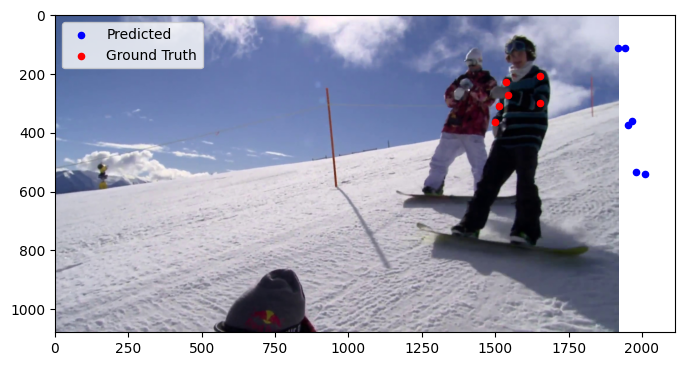

In [57]:
import matplotlib.pyplot as plt
import cv2

def visualize_keypoints(image_path, pred_keypoints, gt_keypoints):
    # 이미지 읽기
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 플롯 설정
    plt.figure(figsize=(8, 8))
    plt.imshow(img)

    # 예측된 키포인트 그리기 (파란색)
    for pred in pred_keypoints:
        plt.scatter(pred[0], pred[1], color='blue', label='Predicted', s=20)

    # 실제 키포인트 그리기 (빨간색)
    for gt in gt_keypoints:
        plt.scatter(gt[0], gt[1], color='red', label='Ground Truth', s=20)

    # 중복되는 범례 항목을 제거하기 위함
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    # 플롯 표시
    plt.show()
    
# 이미지 경로와 예측된 키포인트 및 실제 키포인트
image_path = test_image[32]
pred_keypoints = vit_pose_result[32]
gt_keypoints =  test_label[32]['label'][10: 16]

# 시각화 함수 호출
visualize_keypoints(image_path, pred_keypoints, gt_keypoints)

In [21]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# import cv2

# def visualize_bbox_and_keypoints(image_path, bbox, keypoints):
#     image = cv2.imread(image_path)
#     image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     # 이미지 크기 가져오기
#     img_height, img_width, _ = image.shape

#     # bounding box 좌표
#     x1, y1, x2, y2 = bbox
#     width = x2 - x1
#     height = y2 - y1

#     # 이미지와 bounding box를 함께 그리기 위한 빈 캔버스 생성
#     fig, ax = plt.subplots(1)
#     ax.imshow(image_rgb)

#     # bounding box 그리기
#     rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
#     ax.add_patch(rect)

#     # 예측된 키포인트 그리기
#     for kp in keypoints:
#         if kp[0] != None and kp[1] != None:
#             plt.plot(kp[0], kp[1], 'bo')  # 키포인트 그리기

#     # 그래프 설정 및 출력
#     plt.xlabel('X-axis')
#     plt.ylabel('Y-axis')
#     plt.title('Bounding Box and Predicted Keypoints')
#     plt.grid(True)
#     plt.show()

# # 예시로 첫 번째 이미지를 시각화
# visualize_bbox_and_keypoints(test_image[7], get_bbox_from_center_scale(test_label[7]['center'], test_label[7]['scale']), vit_pose_result[7])

## Media Pipe evaluation

In [25]:
import mediapipe as mp
import cv2
import numpy as np
from tqdm import tqdm

# MediaPipe 초기화
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)

# # PCK 계산 함수 (Bounding Box 크기를 기준으로 정규화)
# def calculate_pck(predicted, ground_truth, bbox_size, threshold=0.5):
#     distances = np.linalg.norm(np.array(predicted) - np.array(ground_truth), axis=1)
#     normalized_distances = distances / bbox_size
#     return np.mean(normalized_distances < threshold)

# # OKS 계산 함수
# def compute_oks(predicted, ground_truth, bbox_size, keypoint_sigmas, threshold=0.5):
#     """OKS 계산 함수"""
#     distances = np.linalg.norm(np.array(predicted) - np.array(ground_truth), axis=1)
#     scaled_distances = distances / bbox_size
#     oks = np.exp(-scaled_distances**2 / (2 * (keypoint_sigmas ** 2)))
#     return np.mean(oks > threshold)

# # mAP 계산 함수
# def calculate_map(oks_scores, thresholds):
#     """mAP(mean Average Precision) 계산 함수"""
#     ap_scores = {t: [] for t in thresholds}
    
#     # 각 threshold에 대해 AP 계산
#     for t in thresholds:
#         aps = [oks >= t for oks in oks_scores]
#         ap_scores[t] = np.mean(aps)
    
#     # mAP 출력
#     for t, score in ap_scores.items():
#         print(f'mAP @ OKS threshold {t}: {score:.4f}')
    
#     return ap_scores

# MediaPipe 평가 함수
def evaluate_mediapipe(image_paths, image_labels, thresholds):
    total_pck_score = 0
    pck_all_list = []
    pose_result = []

    # MPII 데이터셋의 왼쪽, 오른쪽 어깨, 팔꿈치, 손목에 해당하는 6개 키포인트 인덱스
    keypoint_indices = {
        'left_shoulder': 11,  # MediaPipe에서 왼쪽 어깨
        'left_elbow': 13,     # MediaPipe에서 왼쪽 팔꿈치
        'left_wrist': 15,     # MediaPipe에서 왼쪽 손목
        'right_shoulder': 12, # MediaPipe에서 오른쪽 어깨
        'right_elbow': 14,    # MediaPipe에서 오른쪽 팔꿈치
        'right_wrist': 16     # MediaPipe에서 오른쪽 손목
    }

    # MPII 데이터셋에서 왼쪽 어깨, 팔꿈치, 손목, 오른쪽 어깨, 팔꿈치, 손목의 인덱스
    mpii_indices = [10, 11, 12, 13, 14, 15]  # MPII에서 어깨, 팔꿈치, 손목에 해당하는 인덱스

    # MediaPipe의 결과와 MPII 포즈 레이블 비교
    for i, img_path in tqdm(enumerate(image_paths)):
        # 이미지 읽기
        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # MediaPipe 포즈 추정 수행
        result = pose.process(image_rgb)

        if not result.pose_landmarks:
            # print(f'No pose detected in {img_path, i}')
            pose_result.append([])
            continue

        # MediaPipe의 키포인트 추출
        predicted_kpts = []
        for name, idx in keypoint_indices.items():
            landmark = result.pose_landmarks.landmark[idx]
            predicted_kpts.append([landmark.x * image.shape[1], landmark.y * image.shape[0]])  # (x, y) 좌표 변환

        predicted_kpts = np.array(predicted_kpts)

        # Ground Truth에서 어깨, 팔꿈치, 손목에 해당하는 키포인트만 추출
        label_data = image_labels[i]
        gt_kpts = np.array(label_data['label'])
        gt_kpts_selected = gt_kpts[mpii_indices, :2]  # MPII에서 어깨, 팔꿈치, 손목에 해당하는 좌표만 선택

        # 유효한 Ground Truth 키포인트만 사용
        final_predicted_kpts = []
        final_gt_kpts = []
        for j, (gt_kpt, pred_kpt) in enumerate(zip(gt_kpts_selected, predicted_kpts)):
            if gt_kpt[0] != -1 and gt_kpt[1] != -1:
                final_predicted_kpts.append(pred_kpt)
                final_gt_kpts.append(gt_kpt)
        
        if not final_predicted_kpts or not final_gt_kpts:
            print(f'Skipping {img_path} due to invalid ground truth')
            continue

        # Bounding box 크기 계산 (이미지 크기를 사용하여 Bounding box 크기를 추정)
        bbox_size = max(image.shape[0], image.shape[1])
        center = label_data['center']  # 라벨 데이터에서 center 가져오기
        scale = label_data['scale']    # 라벨 데이터에서 scale 가져오기
        
        # Bounding box 계산
        bbox = get_bbox_from_center_scale(center, scale)
        bbox_size = max(bbox[2] - bbox[0], bbox[3] - bbox[1])  # Bounding box 크기 (너비, 높이 중 더 큰 값)
        
        # OKS 계산 및 저장
        if len(final_predicted_kpts) == 6 and len(final_gt_kpts) == 6:
            # PCK 계산
            pck_list = calculate_pck(np.array(final_predicted_kpts), np.array(final_gt_kpts), bbox_size, thresholds)
            pck_all_list.append(pck_list)
            # total_pck_score += pck_score
            
            # oks = compute_oks(final_predicted_kpts, final_gt_kpts, bbox_size, keypoint_sigmas)
            # oks_scores.append(oks)

        pose_result.append(final_predicted_kpts)
    
    avg_pck = np.mean(pck_all_list)
    print(f'avg_PCK: {avg_pck:.4f}')

    # map_score = calculate_map(oks_scores, thresholds)

    return pose_result, pck_all_list

# 사용할 OKS threshold
thresholds = np.arange(0., 1., 0.01)
# 키포인트 가중치 설정 (보통 COCO의 sigmas 값을 사용)
# mediapipe_keypoint_sigmas = np.array([0.62, 0.72, 0.79, 0.79, 0.72, 0.62])
mediapipe_pose_result, mediapipe_pck_list = evaluate_mediapipe(test_image_100, test_label_100, thresholds)


I0000 00:00:1729163495.507838  121972 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1729163495.522337  123135 gl_context.cc:357] GL version: 3.0 (OpenGL ES 3.0 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: D3D12 (Intel(R) UHD Graphics)
500it [00:30, 16.16it/s]

avg_PCK: 0.7393


In [26]:
print(test_image[0])

./MPII/images/000004812.jpg


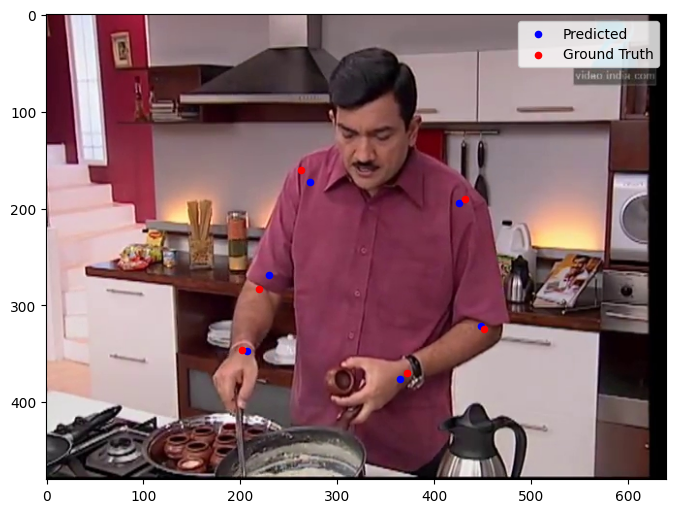

In [28]:
# 이미지 경로와 예측된 키포인트 및 실제 키포인트
image_path = test_image[6]
pred_keypoints = mediapipe_pose_result[6]
gt_keypoints =  test_label[6]['label'][10: 16]

# 시각화 함수 호출
visualize_keypoints(image_path, pred_keypoints, gt_keypoints)

## PCK CURVE 비교

In [29]:
print(len(vit_pck_list))
print(len(mediapipe_pck_list))

490
442


In [32]:
# PCK Curve 그리기 및 AUC 계산 함수
def plot_curve_with_auc(pck_list, thresholds, name):
    sum_auc = 0
    for i in range(len(pck_list)):
        auc_temp = np.trapz(pck_list[i], thresholds)
        sum_auc += auc_temp

    # PCK 평균 계산
    avg_pck = []
    for i in range(len(thresholds)):
        temp = 0
        for j in range(len(pck_list)):
            temp += pck_list[j][i]
        avg_temp = temp / len(pck_list)
        avg_pck.append(avg_temp)
    
    # AUC 계산 (사다리꼴 적분)
    auc = np.trapz(avg_pck, thresholds)
    
    # PR 커브 그리기
    plt.figure()
    plt.plot(thresholds, avg_pck, marker='o')

    # 그래프 레이블 설정
    plt.xlabel('THRESHOLD')
    plt.ylabel('PCK')
    plt.title(f'{name} PCK Curve (AUC: {auc:.4f})')

    # x축과 y축을 0부터 1로 고정
    plt.xlim([0, 1])
    plt.ylim([0, 1])

    # 그래프 표시
    plt.grid(True)
    plt.show()

    # AUC 값 반환
    return sum_auc / len(pck_list), auc

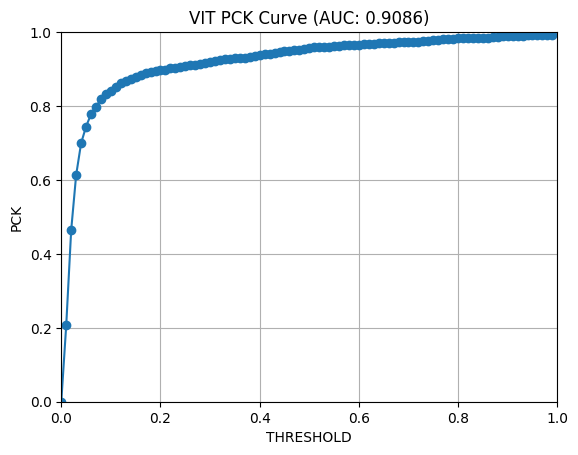

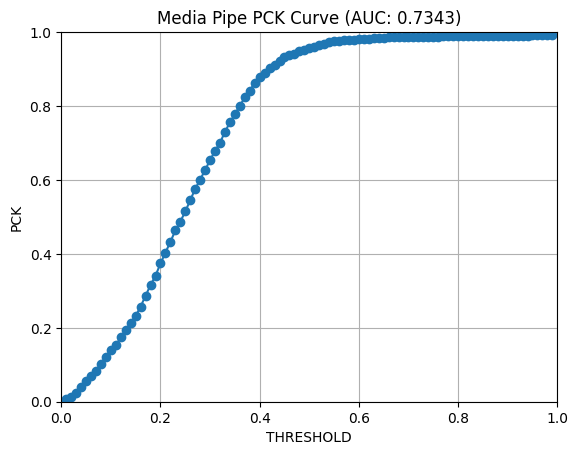

VIT AUC : 0.9086,    VIT AUC avg : 0.9085884353741496
Media Pipe AUC : 0.7343,    Media Pipe AUC : 0.734330693815988


In [33]:
curve_thresholds = np.arange(0., 1., 0.01)
vit_auc, vit_auc_avg = plot_curve_with_auc(vit_pck_list, curve_thresholds, 'VIT')
mediapipe_auc, mediapipe_auc_avg = plot_curve_with_auc(mediapipe_pck_list, curve_thresholds, 'Media Pipe')
print(f'VIT AUC : {vit_auc:.4f},    VIT AUC avg : {vit_auc_avg}')
print(f'Media Pipe AUC : {mediapipe_auc:.4f},    Media Pipe AUC : {mediapipe_auc_avg}')

In [258]:
# media pipe 가 threshold를 후하게 줬을 때 성능이 더 좋다
# vit는 real time이 아니기 때문에 더 정밀한 애들한테 성능이 좋다.